In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from IPython.display import HTML

In [2]:
with open('../data/velodyne/training/test/001111.bin', 'rb') as f:
    d = np.fromfile(f, dtype=np.float32)
    print(d.shape)

(446920,)


In [3]:
print(446920/4)

111730.0


In [4]:
d = d.reshape((111730,4))

In [11]:
train_datapath = '../data/velodyne/training/velodyne/'
vlp_streampath = '../data/2011_09_26/2011_09_26_drive_0005_sync/velodyne_points/data/'

In [6]:
def scale_to_255(a, min, max, dtype=np.uint8):
    """ Scales an array of values from specified min, max range to 0-255
        Optionally specify the data type of the output (default is uint8)
    """
    return (((a - min) / float(max - min)) * 255).astype(dtype)

In [7]:
def birds_eye_point_cloud(points,
                          side_range=(-10, 10),
                          fwd_range=(-10,10),
                          res=0.1,
                          min_height = -2.73,
                          max_height = 1.27,
                          saveto=None):
    """ Creates an 2D birds eye view representation of the point cloud data.
        You can optionally save the image to specified filename.

    Args:
        points:     (numpy array)
                    N rows of points data
                    Each point should be specified by at least 3 elements x,y,z
        side_range: (tuple of two floats)
                    (-left, right) in metres
                    left and right limits of rectangle to look at.
        fwd_range:  (tuple of two floats)
                    (-behind, front) in metres
                    back and front limits of rectangle to look at.
        res:        (float) desired resolution in metres to use
                    Each output pixel will represent an square region res x res
                    in size.
        min_height:  (float)(default=-2.73)
                    Used to truncate height values to this minumum height
                    relative to the sensor (in metres).
                    The default is set to -2.73, which is 1 metre below a flat
                    road surface given the configuration in the kitti dataset.
        max_height: (float)(default=1.27)
                    Used to truncate height values to this maximum height
                    relative to the sensor (in metres).
                    The default is set to 1.27, which is 3m above a flat road
                    surface given the configuration in the kitti dataset.
        saveto:     (str or None)(default=None)
                    Filename to save the image as.
                    If None, then it just displays the image.
    """
    x_lidar = points[:, 0]
    y_lidar = points[:, 1]
    z_lidar = points[:, 2]
    # r_lidar = points[:, 3]  # Reflectance

    # INDICES FILTER - of values within the desired rectangle
    # Note left side is positive y axis in LIDAR coordinates
    ff = np.logical_and((x_lidar > fwd_range[0]), (x_lidar < fwd_range[1]))
    ss = np.logical_and((y_lidar > -side_range[1]), (y_lidar < -side_range[0]))
    indices = np.argwhere(np.logical_and(ff,ss)).flatten()

    # CONVERT TO PIXEL POSITION VALUES - Based on resolution
    x_img = (-y_lidar[indices]/res).astype(np.int32) # x axis is -y in LIDAR
    y_img = (x_lidar[indices]/res).astype(np.int32)  # y axis is -x in LIDAR
                                                     # will be inverted later

    # SHIFT PIXELS TO HAVE MINIMUM BE (0,0)
    # floor used to prevent issues with -ve vals rounding upwards
    x_img -= int(np.floor(side_range[0]/res))
    y_img -= int(np.floor(fwd_range[0]/res))

    # CLIP HEIGHT VALUES - to between min and max heights
    pixel_values = np.clip(a = z_lidar[indices],
                           a_min=min_height,
                           a_max=max_height)

    # RESCALE THE HEIGHT VALUES - to be between the range 0-255
    pixel_values  = scale_to_255(pixel_values, min=min_height, max=max_height)

    # FILL PIXEL VALUES IN IMAGE ARRAY
    x_max = int((side_range[1] - side_range[0])/res)
    y_max = int((fwd_range[1] - fwd_range[0])/res)
    im = np.zeros([y_max, x_max], dtype=np.uint8)
    im[-y_img, x_img] = pixel_values # -y because images start from top left
    # Convert from numpy array to a PIL image
    im = Image.fromarray(im)

    # SAVE THE IMAGE
    if saveto is not None:
        im.save(saveto)
        
    return im

In [8]:
HRES = 0.35         # horizontal resolution (assuming 20Hz setting)
VRES = 0.4          # vertical res
VFOV = (-24.9, 2.0) # Field of view (-ve, +ve) along vertical axis
Y_FUDGE = 5         # y fudge factor for velodyne HDL 64E

In [9]:
im = birds_eye_point_cloud(d, side_range=(-30, 30), fwd_range=(-30, 30), res=0.1, saveto=None)

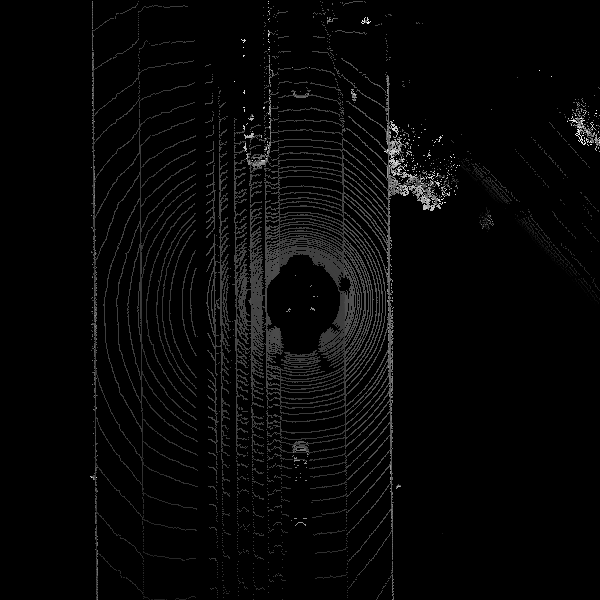

In [10]:
im

In [13]:
for fn in os.listdir(vlp_streampath):
    with open(os.path.join(vlp_streampath, fn), 'rb') as f:
        d = np.fromfile(f, dtype=np.float32)
        d = d.reshape((int(d.size/4), 4))
        im = birds_eye_point_cloud(d, side_range=(-30, 30), fwd_range=(-30, 30), res=0.1, saveto='./point-cloud-images/{}'.format(fn.replace('bin','png')))

In [14]:
!ffmpeg -pattern_type glob -i './point-cloud-images/*.png'  -vcodec libx264 -s 1280x720 -pix_fmt yuv420p vlp-viz.mp4

ffmpeg version 4.0.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with Apple LLVM version 9.1.0 (clang-902.0.39.2)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.0.1 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-frei0r --enable-libass --enable-libfdk-aac --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopus --enable-librtmp --enable-libspeex --enable-libtheora --enable-libvorbis --enable-libvpx --enable-libx264 --enable-libxvid --enable-opencl --enable-videotoolbox --disable-lzma --enable-libopenjpeg --disable-decoder=jpeg2000 --extra-cflags=-I/usr/local/Cellar/openjpeg/2.3.0/include/openjpeg-2.3 --enable-nonfree
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.10

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('vlp-viz.mp4'))